In [4]:
import pandas as pd
from load_files_to_db import cf_to_stations
from file_header_types import FileHeaderType
from file_types import RawFile, CleanedFile
from models import verbose_engine
from sqlalchemy.orm import sessionmaker
from models import Trip
from models import engine
import numpy as np
import matplotlib.pyplot as plt
import helpers

# Citibike data analysis
## Citibike provides [data](https://ride.citibikenyc.com/system-data) on each trip on it's system as part of it's agreement with nyc


### It's in bigass csv files for every month, with most files in the ~300-400 mb range (too big to reasonably analyze in excel)
### As part of seisun's citibike analysis we'll build a pipeline for downloading, cleaning and storing the data before we can even start the analysis (included in the agreement free of charge)

# Data investigation/cleaning

### What's the data even look like?
Once we've downloaded the data we take a peek at one of the files to understand the general structure
The raw data looks like this 👇

In [5]:
helpers.get_sample_file(n=1000)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,C09E4093905089BD,classic_bike,2022-07-23 11:34:57,2022-07-23 11:45:08,Melrose St & Broadway,4801.04,Myrtle Ave & Grove St,4816.05,40.697481,-73.935877,40.699050,-73.915160,member
1,374630DB5822C392,electric_bike,2022-07-29 18:19:08,2022-07-29 18:26:50,E 68 St & 3 Ave,6896.16,E 85 St & York Ave,7146.04,40.767128,-73.962246,40.775369,-73.948034,member
2,4F73CA25880A1215,electric_bike,2022-07-16 16:30:58,2022-07-16 17:39:18,W 37 St & 10 Ave,6611.02,Knickerbocker Ave & Cooper St,4582.05,40.756604,-73.997901,40.690810,-73.904480,member
3,ECD6EE19C0CC1D31,electric_bike,2022-07-17 17:35:57,2022-07-17 18:03:36,W 37 St & 10 Ave,6611.02,6 Ave & Broome St,5610.09,40.756604,-73.997901,40.724310,-74.004730,member
4,44D0987673B9997D,classic_bike,2022-07-11 07:56:29,2022-07-11 07:59:15,E 68 St & 3 Ave,6896.16,E 66 St & Madison Ave,6969.08,40.767128,-73.962246,40.768009,-73.968453,member
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0F87E6AA53284B9F,classic_bike,2022-07-04 13:37:48,2022-07-04 13:44:31,34 St & 35 Ave,6605.08,Steinway St & Broadway,6711.13,40.756933,-73.926223,40.759058,-73.918975,casual
996,3B433CD081477953,electric_bike,2022-07-24 04:47:36,2022-07-24 05:00:46,East End Ave & E 86 St,7113.08,West End Ave & W 94 St,7524.09,40.775186,-73.944461,40.794165,-73.974124,member
997,5CFE90B3DCDFC7DE,classic_bike,2022-07-02 20:21:59,2022-07-02 20:29:46,East End Ave & E 86 St,7113.08,E 75 St & 3 Ave,6991.12,40.775186,-73.944461,40.771129,-73.957723,member
998,EC034412314B3701,electric_bike,2022-07-01 07:39:09,2022-07-01 07:51:09,Washington Pl & Broadway,5755.01,Madison Av & E 51 St,6659.09,40.729039,-73.994046,40.758630,-73.975130,member


There's a record for each trip including the start and the end of the trip, which station and some metadata about the user taking the trip and the station

Because the data was too large to read directly from csvs we had to load it to a database. We chose postgres to align ourselves with Alza's technologies despite learning to hate postgres by the end of this exercise. 

Because a lot of the data about the details of a specific station were duplicated we split the data into two tables instead of loading it as is (e.g. start_lat, start_long, station_name). 

Trips and Stations which were linked by the key "citi_station_id" -> start/end_station_id. The stations table has all the data that was otherwise duplicated (e.g. station lat/long, station_name) and we were able to add some additional metadata like when the station was first and last seen

In [6]:
trips_sample_df = pd.read_sql("select * from prod.trips limit 100", engine)
stations_df = pd.read_sql("select * from prod.stations", engine)

### Trips table sample

In [7]:
trips_sample_df

,trip_id,started_at,ended_at,start_station_name,end_station_name,membership_status,rideable_type,filename
0,1,2021-02-26 16:38:54,2021-02-26 16:44:37,E 84 St & Park Ave,E 78 St & 2 Ave,casual,docked_bike,extracted_data/202102-citibike-tripdata.csv
1,2,2021-02-17 11:09:11,2021-02-17 11:26:47,Macon St & Nostrand Ave,Bond St & Fulton St,member,docked_bike,extracted_data/202102-citibike-tripdata.csv
2,3,2021-02-26 18:33:29,2021-02-26 19:05:41,Macon St & Nostrand Ave,Lefferts Pl & Franklin Ave,casual,docked_bike,extracted_data/202102-citibike-tripdata.csv
3,4,2021-02-26 12:48:35,2021-02-26 13:07:24,Macon St & Nostrand Ave,Bond St & Fulton St,member,docked_bike,extracted_data/202102-citibike-tripdata.csv
4,5,2021-02-25 17:23:22,2021-02-25 17:28:20,Madison Ave & E 26 St,W 37 St & 5 Ave,member,docked_bike,extracted_data/202102-citibike-tripdata.csv
...,...,...,...,...,...,...,...,...
95,96,2021-02-28 17:41:45,2021-02-28 18:36:30,Myrtle Ave & Marcy Ave,49 St & 31 Ave,casual,docked_bike,extracted_data/202102-citibike-tripdata.csv
96,97,2021-02-22 22:42:32,2021-02-22 23:57:40,E 33 St & 5 Ave,E 2 St & Avenue B,casual,docked_bike,extracted_data/202102-citibike-tripdata.csv
97,98,2021-02-17 12:56:58,2021-02-17 13:02:19,E 84 St & Park Ave,E 77 St & 3 Ave,member,docked_bike,extracted_data/202102-citibike-tripdata.csv
98,99,2021-02-26 09:20:53,2021-02-26 09:23:53,Carroll St & Smith St,Union St & Nevins St,member,docked_bike,extracted_data/202102-citibike-tripdata.csv


### Stations table sample

In [8]:
stations_df

,station_id,station_name,lat,long,first_trip_at,last_trip_at,created_at
0,10235,Anthony Ave & E Burnside Ave,40.751184,-73.971387,2021-09-29 21:14:41.000,2021-09-29 21:16:32.000,2022-10-18 14:34:00.569310
1,34518,Apache,40.669767,-73.994744,2018-03-14 13:26:35.138,2018-03-23 13:54:54.720,2022-10-18 14:50:12.685604
2,28117,Adventures NYC,40.773769,-73.971170,2017-06-17 11:25:07.000,2017-06-17 17:45:32.000,2022-10-18 14:45:19.121418
3,45076,W 45 St & 6 Ave -,40.756687,-73.982577,2019-04-01 06:29:34.441,2019-04-29 07:51:00.657,2022-10-18 14:58:17.236418
4,28425,LPI Facility,0.000000,0.000000,2017-06-27 15:18:32.000,2017-06-27 16:16:34.000,2022-10-18 14:45:19.121418
...,...,...,...,...,...,...,...
1849,5935,Clinton St & Cherry St,40.711471,-73.986726,2021-06-02 18:51:10.000,2022-08-01 13:30:12.000,2022-10-18 14:30:12.508571
1850,5970,Creston Ave & E 181 St,40.854900,-73.902810,2021-06-09 17:06:40.000,2022-07-31 21:38:59.000,2022-10-18 14:30:12.508571
1851,17,11 Ave & Prospect Ave,40.656290,-73.977335,2021-02-20 09:55:41.000,2022-07-31 21:43:38.000,2022-10-18 14:26:15.494469
1852,27,16th St & 4th Ave,40.666197,-73.992466,2021-02-17 20:23:43.000,2022-07-31 23:37:52.000,2022-10-18 14:26:15.494469


Okay, we have two tables, trips and stations linked together by the citi_station_id. 

**Trips Table**
- **started_at**: Seems pretty self explanatory as when the trip started
- **ended_at**: ditto, trip ended at. We should subtract ended_at from started_at for trip duration
- **start/end station_id**: the station the trip started and ended at
- **membership_status**: looks like it's broken out between members and "casual". It's unclear if casual is only per-per-use people or people with multi-day passes. Also unclear if those are the only 2 available values
- **rideable_type**: Unclear what this means. I think it's electric vs normal? What's a "docked_bike" though? Aren't all bikes docked?
- **filename**: I added this data as to which file this record came from


## What does rideable_type and membership_status mean?

In [10]:
df_distance_traveled_over_time = pd.read_sql("""select 
date_trunc('week', started_at) as started_week,
rideable_type,
avg(power(power(strt.lat - nd.lat, 2) + power(strt.long - nd.long, 2), .5) * 69) as distance,
count(1) num
from prod.trips t
left join prod.stations strt on strt.station_name = t.start_station_name
left join prod.stations nd on nd.station_name = t.end_station_name
group by 1,2""", engine)

In [11]:
### Let's look at the values of rideable_type over time to see if we can infer

<AxesSubplot: title={'center': 'Number of trips by rideable_type over time'}, xlabel='started_week'>

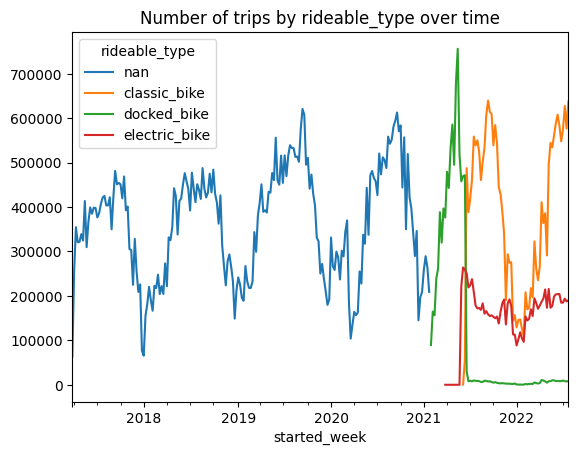

In [12]:
df_distance_traveled_over_time.pivot(index='started_week', columns='rideable_type', values='num')\
.plot(title='Number of trips by rideable_type over time')

We can see that they mostly switched from the term "docked_bike" to "classic_bike" in June 2021 and it seems like it is just e-bike vs normal bike. 

We'll merge the two going forward for simplicity

### What're the possible values for "membership_status"?
Let's do a quick analysis to make sure we loosely understand the values of membership status and whether the data is clean

In [13]:
df_distance_traveled_over_time_mem_stat = pd.read_sql("""select 
date_trunc('week', started_at) as started_week,
membership_status,
avg(power(power(strt.lat - nd.lat, 2) + power(strt.long - nd.long, 2), .5) * 69) as distance,
count(1) num
from prod.trips t
left join prod.stations strt on strt.station_name = t.start_station_name
left join prod.stations nd on nd.station_name = t.end_station_name
group by 1,2""", engine)

<AxesSubplot: xlabel='started_week'>

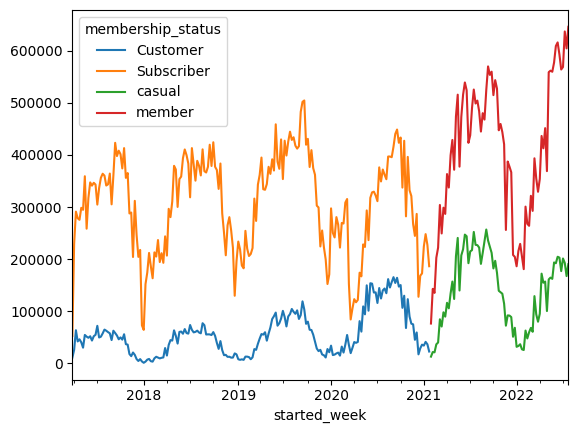

In [14]:
df_distance_traveled_over_time_mem_stat.pivot(index='started_week', columns='membership_status', values='num').plot()

The data above looks largely sane. Interesting sidenote (although somewhat obvious) that casual usage of citibike drops almost to 0 
in winter while membership usage maintains ~40% of their usage

### Distribution of start/end times
While the time looks fairly straightforward lets make sure there isn't dirty data in the start/end times (like crazy dates way out in the future/past)

In [15]:
df_started_at_data_cleaning = pd.read_sql_query("""select date_trunc('hour', started_at) started_at_minute, count(1) num from prod.trips
group by 1""", engine)


df_ended_at_data_cleaning = pd.read_sql_query("""select date_trunc('hour', ended_at) ended_at_minute, count(1) num from prod.trips
group by 1""", engine)

plt.rcParams['figure.figsize'] = [15,5]

<AxesSubplot: title={'center': 'Distribution of "started_at" times over time'}, xlabel='started_at_minute'>

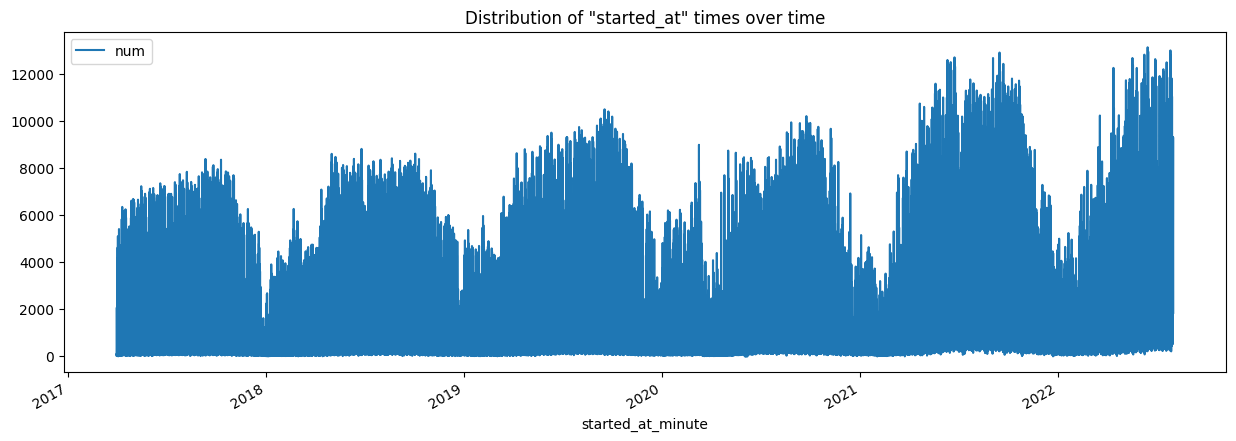

In [16]:
# Check max's and mins
df_started_at_data_cleaning.set_index('started_at_minute').plot(title='Distribution of "started_at" times over time')

<AxesSubplot: title={'center': 'Distribution of "ended_at" times over time'}, xlabel='ended_at_minute'>

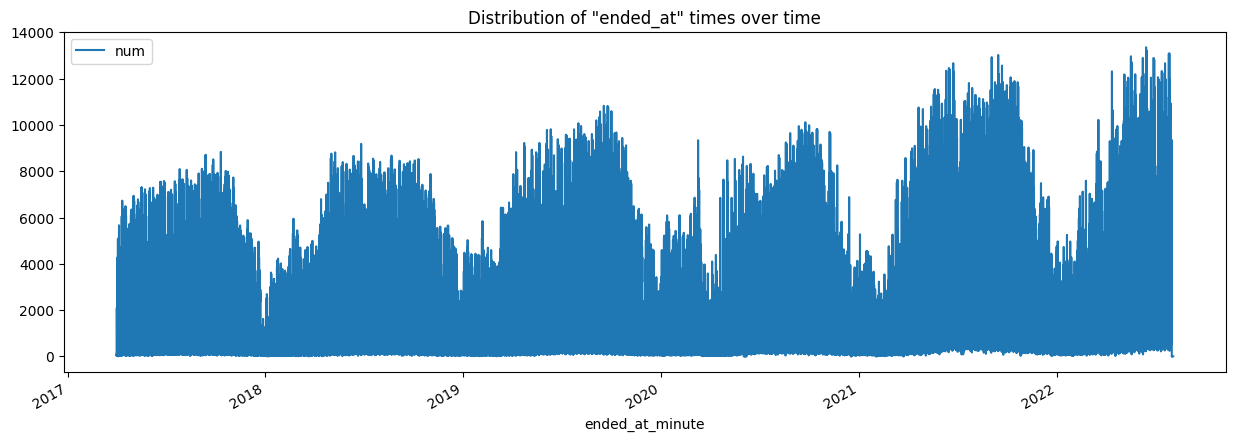

In [17]:
df_ended_at_data_cleaning.set_index('ended_at_minute').plot(title='Distribution of "ended_at" times over time')

Given that the data was supposed to end in Sept and we see records for Oct we know there's at least some dirty data on the ended times. However looking at the plot above we can see that's a mostly negligable number of trips and shouldn't affect our analysis

### What's the distribution of the trip durations?
While the times look sane, do the start/end times make sense together? Are there trips with an end time before a start time? End time too far out?

In [18]:
df_intervals = pd.read_sql("""select 
	date_trunc('minute', ended_at - started_at) as duration_minutes,
	membership_status,
	count(1) num
from prod.trips
group by 1,2""", engine)

<AxesSubplot: title={'center': 'Distribution of trip durations'}, xlabel='duration_minutes'>

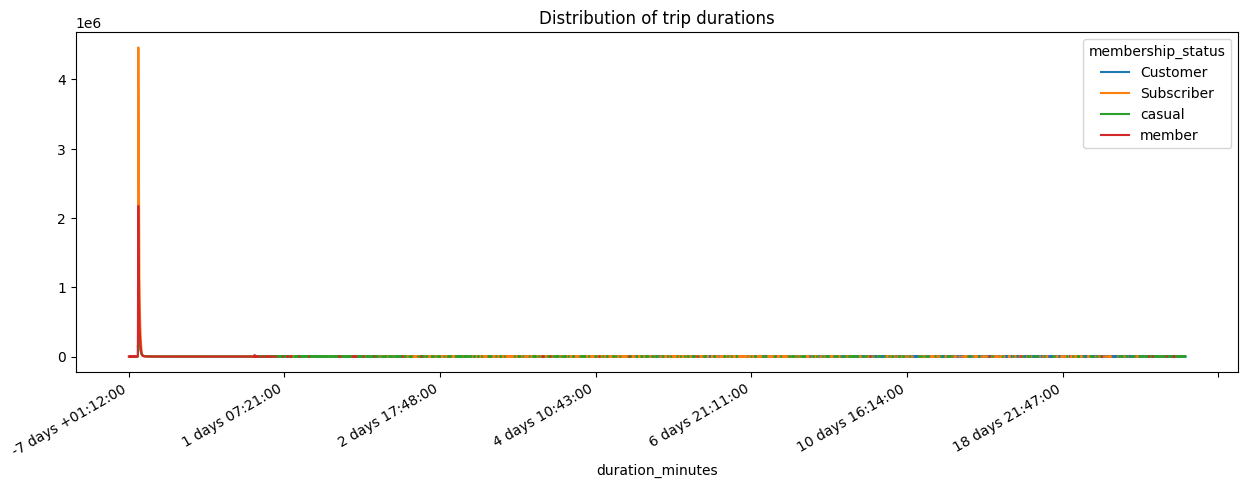

In [19]:
df_intervals.pivot(index='duration_minutes', columns='membership_status', values='num').plot(title='Distribution of trip durations')

Okay, we can see that there are both negative trip durations end times as well as some trips that allegidly last for multiple days.
Let's see how much the dirty data we have will affect our analysis

In [20]:
df_intervals['duration_days'] = (df_intervals['duration_minutes'] / pd.Timedelta('1 day')).astype('int')

In [21]:
tmp = pd.DataFrame(df_intervals.groupby('duration_days')['num'].sum())
tmp['pct_total'] = tmp['num'] / tmp['num'].sum()

In [22]:
tmp[:20]

,num,pct_total
duration_days,,
-6,8,6.911025e-08
-5,5,4.319390e-08
-4,12,1.036654e-07
-3,8,6.911025e-08
-2,14,1.209429e-07
-1,12,1.036654e-07
0,115686186,9.993876e-01
1,53492,4.621057e-04
2,4443,3.838210e-05


You can see that 99.8% of rides do happen within 1 day. While that's generally good, .2% dirty data isn't trivial esp with outliers that might drastically affect averages (e.g. average trip length is gonna be skewed by the 13 day trip). We'll filter out all rides shorter than 0 minutes and longer than 2 hours

## So what changes are we making to the data for our analysis?

We've decided we want to make 2 changes to the data:

* Combine 2 of rideable_type fields as we believe they just changed from using one term to another
* Discard any data with a trip duration outside of 0-120 minutes. We'll create a table called prod.trips_cleaned with these changes to the underlying trips table

``` sql
create table prod.trips_cleaned as 
select 
	started_at,
	ended_at,
	start_station_id,
	end_station_id,
	membership_status,
	case when rideable_type = 'docked_bike' then 'classic_bike' else rideable_type end as rideable_type,
filename
from prod.trips
where ended_at - started_at between interval '0' minute and interval '120' minute
```


# Analysis

#### Most popular for citibike usage (aka "why does Arturo never get a bike when he wants it")

In [ ]:
df_weekday_vs_hours = pd.read_sql("""select date_part('dow', started_at) day_of_week, date_part('hour', started_at) hr, count(1) num from prod.trips_cleaned
group by 1,2""", engine)

In [ ]:
df_weekday_vs_hours = df_weekday_vs_hours.astype(int)

In [ ]:
df_weekday_vs_hours.pivot(index='hr', columns='day_of_week', values='num').style.background_gradient(cmap ='Reds').set_properties(**{'font-size': '20px'})

### Plotted differently

In [ ]:
df_weekday_vs_hours.pivot(index='hr', columns='day_of_week', values='num').plot()

### What are the most popular citibike trips by start/end (aka "Are there cute date ideas hiding in the data?")

In [ ]:
df_popular_trips = pd.read_sql("""
with t as (
select 
	start_station_name, 
	end_station_name,
	case when start_station_name = end_station_name then true else false end as same_station,
	avg(ended_at - started_at) as trip_time,
	
	count(1) num from prod.trips_cleaned
group by 1,2)

select 
	strt.station_name start_station, 
	nd.station_name end_station, 
	same_station,
	trip_time,
	power(power(strt.lat - nd.lat, 2) + power(strt.long - nd.long, 2), .5) * 69 as distance,
	num from t
left join prod.stations strt on strt.station_name = t.start_station_name
left join prod.stations nd on nd.station_name  = t.end_station_name""", engine)

In [ ]:
df_popular_trips.sort_values(by='num', ascending=False)[:20]

### As we see the most popular trips start and end at the same place (we'll call these _tourist trips_). **What about trips meant for travel?**

In [ ]:
df_popular_trips[df_popular_trips['same_station'] == False].sort_values(by='num', ascending=False)[:20]

### As we can see, the data shows the most popular trip goes only .6 miles or an 11 minute walk, proving incontrovertibly that walking is dumb no matter how short the distance

In [ ]:
df_trip_time_by_type_of_ride = pd.read_sql("""select 
	date_trunc('day', started_at) as day_started,
	case when start_station_name = end_station_name then true else false end as same_station,
	avg(ended_at - started_at) as trip_time,
	count(1) num from prod.trips_cleaned
group by 1,2""", engine)

### How many trips are "tourist" trips and end at the same dock

In [ ]:
df_trip_time_by_type_of_ride.pivot(index='day_started', columns='same_station', values='num').plot()

### Actually not that many despite the fact that all the most popular trips end at the same dock

### Whats the difference in how long "tourists trips" use the bike for relative to travel trips?

In [ ]:
df_trip_time_by_type_of_ride.pivot(index='day_started', columns='same_station', values='trip_time').plot()

### Looks like they're about the same, except in winter when these "tourist" trips get a lot shorter than the travel trips. Turns out, not all questions are interesting

# Paretto of how involved stations are. What's the distribution of use of stations? How can Daniel insert the word paretto?

In [ ]:
df_involved_stations = pd.read_sql("""with involved_stations as (
	select start_station_name as involved_station from prod.trips_cleaned
	union all
	select end_station_name from prod.trips_cleaned)

select s.station_name, s.lat, s.long, s.first_trip_at, s.last_trip_at, count(1) num from involved_stations i
left join prod.stations s on s.station_name = i.involved_station
group by 1,2,3,4,5""", engine)


In [ ]:
helpers.paretto(df_involved_stations, 'num').plot()

### The top 20% of stations are involved in about 60% of trips. Yet again, we learn that not all questions have interesting answers. I get paid either way

## Members vs Nonmembers (aka "cool kids vs casual

In [ ]:
df_short_rides_member = pd.read_sql_query("""
select 
	membership_status,
	count(1) num
from prod.trips_cleaned
group by 1
""", engine)

In [ ]:
df_short_rides_member.set_index('membership_status').plot.bar()

In [ ]:
df_short_rides_member_casual = pd.read_sql("""select date_trunc('week', started_at), membership_status, count(1) num from prod.trips_cleaned
group by 1,2""", engine)

In [ ]:
df_short_rides_member_casual.pivot(index='date_trunc', columns='membership_status', values='num').plot()

# Stations analysis

## Most popular starting station

In [ ]:
df_most_popular_starting_station = pd.read_sql("""
with strt as (
select start_station_id, count(1) num from prod.trips_cleaned
group by 1
)

select s.station_name, s.citi_station_id, s.lat, s.long, strt.num, first_trip_at, last_trip_at from strt
left join prod.stations s on s.citi_station_id = strt.start_station_id""", engine)


In [ ]:
df_most_popular_starting_station.sort_values('num', ascending=False)[:20]

# Comparison of Ebikes to normal bikes

## What's the distribution of trips with different types of bikes in the fleet over time?

## How much further do people take electric bikes

In [ ]:
df_dist_traveled_by_type = pd.read_sql("""select 
date_trunc('week', started_at) as started_week,
rideable_type,
avg(power(power(strt.lat - nd.lat, 2) + power(strt.long - nd.long, 2), .5) * 69) as distance,
count(1) num
from prod.trips_cleaned t
left join prod.stations strt on strt.citi_station_id = t.start_station_id
left join prod.stations nd on nd.citi_station_id = t.end_station_id
group by 1,2""", engine)

In [ ]:
df_dist_traveled_by_type.pivot(index='started_week', columns='rideable_type', values='distance').plot()

# Single station experience
## Let's hone in on the experience of a single station


In [ ]:
df_single_station_data = pd.read_sql("""
select 
	'start_station' as station_type,
	date_part('dow', started_at) day_of_week, 
	date_part('hour', started_at) hr, 
	count(1) num from prod.trips_cleaned
where start_station_id = '{station_id}'
group by 1,2,3
union all
select 
	'end_station' as station_type,
	date_part('dow', started_at) day_of_week, 
	date_part('hour', started_at) hr, 
	count(1) num from prod.trips_cleaned
where end_station_id = '{station_id}'
group by 1,2,3""".format(station_id='4033.06'), engine)




### Rides _start_ at this station on this distribution

In [ ]:
df_single_station_data[df_single_station_data['station_type'] == 'start_station'][['day_of_week', 'hr', 'num']].pivot(index='hr', columns='day_of_week', values='num').plot()

### Rides end on the station with _this_ distribution

In [ ]:
df_single_station_data[df_single_station_data['station_type'] == 'end_station'][['day_of_week', 'hr', 'num']].pivot(index='hr', columns='day_of_week', values='num').plot()

### Stations with most asymetric number of trips starting vs ending there

In [ ]:
df_asymetric_stations = pd.read_sql("""with starts as (
	select start_station_id, count(1) num from prod.trips_cleaned
	where start_station_id != 'None'
	group by 1),
	
ends as (
	select end_station_id, count(1) num from prod.trips_cleaned
	where end_station_id != 'None'
	group by 1
)

select 
	coalesce(starts.start_station_id, ends.end_station_id) as station_id,
	s.station_name,
	coalesce(starts.num, 0) as starts_num, 
	coalesce(ends.num, 0) as ends_num,
	coalesce(ends.num, 0) - coalesce(starts.num, 0) as additional_bikes
from starts
full outer join ends on ends.end_station_id = starts.start_station_id
left join prod.stations s on s.citi_station_id = starts.start_station_id
order by additional_bikes """, engine)

### Top stations with people asymetrically starting rides there, but not ending them there
(E.g. Stations most likely to be empty)

In [ ]:
df_asymetric_stations.sort_values('additional_bikes')[:20]

### Top stations with people asymetrically ending rides there, but not starting them there
(E.g. Stations most likely to be full)

In [ ]:
df_asymetric_stations.sort_values('additional_bikes', ascending=False)[:20]

The above stations are loosely supported by spot checking street view. The stations with a high "additional bikes" count tend to be full in streetview and those with a large deficit tend to be empty